In [ ]:
!pip install geopandas
!pip install mapclassify

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd
import mapclassify as mc
import numpy as np

In [ ]:
testGDF = gpd.read_file("/content/drive/MyDrive/Junior Year/IW 07/dbGDF.geojson")

In [ ]:
crDF = pd.read_excel(io="/content/drive/MyDrive/Junior Year/IW 07/County_Rural_Lookup.xlsx")
crDF = crDF.drop(3)

In [ ]:
crDF.tail()

,GEOID,2010Pop,2010PctRural
3137,56037,43806,10.916313
3138,56039,21294,46.430920
3139,56041,21118,43.095937
3140,56043,8533,35.954529
3141,56045,7208,54.536626


In [ ]:
header_list = ['GEOID', '2010Pop', '2010PctRural']
crDF = crDF.reindex(columns = header_list)

crDF['GEOID'] = crDF['GEOID'].apply(pd.to_numeric)
crDF.set_index('GEOID', inplace=True)
crDF.head()

,2010Pop,2010PctRural
GEOID,,
1001,54571,42.002162
1003,182265,42.279099
1005,27457,67.789635
1009,57322,89.951502
1011,10914,51.374382


In [ ]:
print(crDF.loc[31039])

In [ ]:
testGDF.set_index('COUNTYFP', inplace=True)
testGDF.head()

,STATEFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,numIncidents,numCasualties,numGuns,geometry,TOTPOP,PCTRURAL,GEOINC,CASRATE
COUNTYFP,,,,,,,,,,,,,,,,,,,,,,,,
31039,31,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477652222,10690952,+41.9158651,-096.7885168,1.0,0.0,1.0,"POLYGON ((-97.01952 42.00410, -97.01952 42.004...",NaN,NaN,NaN,0.000000
53069,53,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680962890,61582307,+46.2946377,-123.4244583,0.0,0.0,0.0,"POLYGON ((-123.43639 46.23820, -123.44759 46.2...",NaN,NaN,NaN,NaN
35011,35,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016819475,29089486,+34.3592729,-104.3686961,0.0,0.0,0.0,"POLYGON ((-104.56739 33.99757, -104.56772 33.9...",NaN,NaN,NaN,NaN
31109,31,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169270569,22849484,+40.7835474,-096.6886584,123.0,37.0,NaN,"POLYGON ((-96.91075 40.78494, -96.91075 40.790...",NaN,NaN,NaN,0.300813
31129,31,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645188,1718484,+40.1764918,-098.0468422,0.0,0.0,0.0,"POLYGON ((-98.27367 40.08940, -98.27367 40.089...",NaN,NaN,NaN,NaN


In [ ]:
testGDF = testGDF.assign(TOTPOP=pd.Series(np.zeros(len(testGDF))).values)
testGDF = testGDF.assign(PCTRURAL=pd.Series(np.zeros(len(testGDF))).values)
testGDF.head()

In [ ]:
for i in testGDF.index:
  try:
    testGDF.loc[int(i), 'TOTPOP'] = crDF.loc[int(i), '2010Pop']
    testGDF.loc[int(i), 'PCTRURAL'] = crDF.loc[int(i), '2010PctRural'] - 50
  except KeyError:
    pass

testGDF = testGDF.assign(GEOINC=pd.Series(np.zeros(len(testGDF))).values)
testGDF['GEOINC'] = testGDF['numIncidents'] * testGDF['PCTRURAL'] / testGDF['TOTPOP'] * 1000

testGDF = testGDF.assign(CASRATE=pd.Series(np.zeros(len(testGDF))).values)
testGDF['CASRATE'] = testGDF['numCasualties'] / testGDF['numIncidents']

testGDF.head()

# Quick Notes for IW Sem


1.   Appended new Data to compiled dataframe
2.   Calculated correlation parameter 'GEOINC'
3.   Mapped and sorted for extreme cases for candidates to analyze



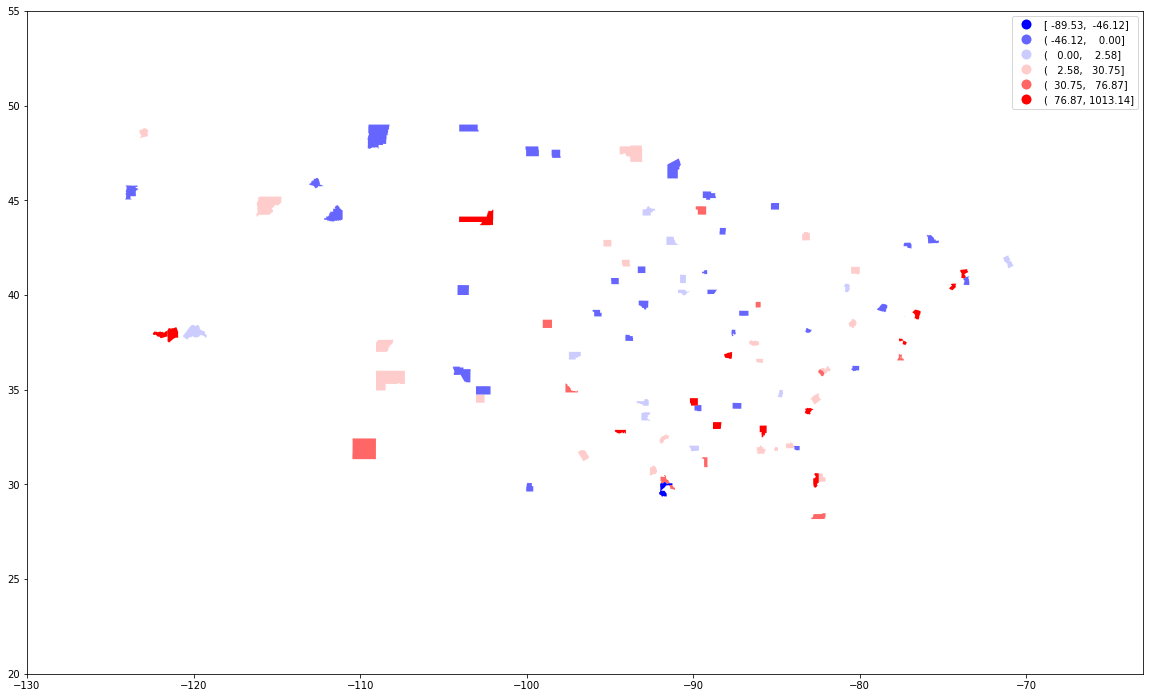

In [ ]:
testGDF = testGDF.set_crs("EPSG:4326")
fig, ax = plt.subplots(figsize=(20, 20))
testGDF.plot(column='GEOINC', cmap='bwr', ax=ax, scheme="boxplot", legend=True)

ax.set_xlim(-130, -63)
ax.set_ylim(20, 55)

plt.show()

In [ ]:
stateDF = pd.read_csv("/content/drive/MyDrive/Junior Year/IW 07/state_fips_master.csv", index_col='fips')
stateDF.head()

,state_name,state_abbr,long_name,sumlev,region,division,state,region_name,division_name
fips,,,,,,,,,
1,Alabama,AL,Alabama AL,40,3,6,1,South,East South Central
2,Alaska,AK,Alaska AK,40,4,9,2,West,Pacific
4,Arizona,AZ,Arizona AZ,40,4,8,4,West,Mountain
5,Arkansas,AR,Arkansas AR,40,3,7,5,South,West South Central
6,California,CA,California CA,40,4,9,6,West,Pacific


In [ ]:
incomeDF = pd.read_excel("/content/drive/MyDrive/Junior Year/IW 07/est18all.xlsx")
incomeDF.head()

,State FIPS Code,County FIPS Code,Median Household Income,90% CI Lower Bound,90% CI Upper Bound
0,0,0,61937,61843,62031
1,1,0,49881,49123,50639
2,1,1,59338,53628,65048
3,1,3,57588,54437,60739
4,1,5,34382,31157,37607


In [ ]:
incomeDF['County FIPS Code'] = incomeDF['State FIPS Code'] * 1000 + incomeDF['County FIPS Code']
incomeDF.set_index('County FIPS Code', inplace=True)
incomeDF.head()

,State FIPS Code,Median Household Income,90% CI Lower Bound,90% CI Upper Bound
County FIPS Code,,,,
0,0,61937,61843,62031
1000,1,49881,49123,50639
1001,1,59338,53628,65048
1003,1,57588,54437,60739
1005,1,34382,31157,37607


In [ ]:
def rowFormatPrint(ind):
  try:
    row = testGDF.loc[ind]
    state = stateDF.loc[int(row['STATEFP']), 'state_name']
    county = row['NAMELSAD']
    pct = row['PCTRURAL']
    inc = row['numIncidents']
    cas = row['numCasualties']
    pop = row['TOTPOP']
    density = pop / row['ALAND'] * 100
    income = incomeDF.loc[ind, 'Median Household Income']

    print(state)
    print(county)
    
    print("Incident Count: {:d}".format(int(inc)))
    print("Casualty Count: {:d}".format(int(cas)))
    print("Median Income: {:d}".format(income))
    print("----------")
  except ValueError:
    pass
  except KeyError:
    pass

for i in testGDF.index:
  row = testGDF.loc[i]
  if row['numIncidents'] > 1000: rowFormatPrint(i)
  if row['GEOINC'] > 55.70: rowFormatPrint(i)

Maryland
Baltimore city
Incident Count: 1681
Casualty Count: 1501
Median Income: 50501
----------
California
Los Angeles County
Incident Count: 1595
Casualty Count: 1683
Median Income: 67986
----------
Pennsylvania
Philadelphia County
Incident Count: 1621
Casualty Count: 1713
Median Income: 46149
----------
Illinois
Cook County
Incident Count: 4879
Casualty Count: 5666
Median Income: 63347
----------
Wisconsin
Milwaukee County
Incident Count: 1117
Casualty Count: 1050
Median Income: 49771
----------
Maryland
Anne Arundel County
Incident Count: 276
Casualty Count: 86
Median Income: 97051
----------
New Jersey
Middlesex County
Incident Count: 55
Casualty Count: 32
Median Income: 87666
----------
California
Contra Costa County
Incident Count: 251
Casualty Count: 266
Median Income: 101463
----------
Virginia
Henrico County
Incident Count: 132
Casualty Count: 65
Median Income: 68581
----------
New York
Westchester County
Incident Count: 90
Casualty Count: 81
Median Income: 94521
----------
